In [1]:
import matplotlib.pyplot as plt

from desc.continuation import solve_continuation_automatic
from desc.backend import jnp, functools, jit
from desc.examples import get
import desc.io
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.geometry import FourierRZToroidalSurface
from desc.grid import Grid, _periodic_spacing, LinearGrid
from desc.equilibrium.coords import get_rtz_grid
from desc.objectives import (
    AspectRatio,
    FixBoundaryR,
    FixBoundaryZ,
    FixCurrent,
    FixPressure,
    FixPsi,
    ForceBalance,
    ObjectiveFunction,
    BallooningStability,
    EffectiveRadius,
    ParallelConnectionLength,
)
from desc.optimize import Optimizer
from desc.plotting import plot_comparison, plot_section


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


DESC version 0.12.2+415.g7a626261f.dirty,using JAX backend, jax version=0.4.31, jaxlib version=0.4.31, dtype=float64
Using device: CPU, with 25.70 GB available memory


## Methods ##

In [2]:
# Function to get value of a parameter directly
def get_value(eq,name,grid):
    return eq.compute(name,grid=grid)[name]

# Function to get the straight field line coordinate system, need iota for jit
# @functools.partial(jit, static_argnames=["rho","alpha","n_pol","n_points"])
def get_field_line_grid(eq,iota,rho=0.5,alpha=0,n_pol = 4,n_points = 200):
    n_tor = n_pol/(iota*eq.NFP)
    good_grid = get_rtz_grid(
        eq,
        jnp.array(rho),
        # np.array(rho),
        jnp.array(alpha),
        # np.linspace(0,2*n_tor*np.pi,n_points*n_pol),
        jnp.linspace(0,2*n_tor*jnp.pi,n_points*n_pol),
        coordinates="raz",
        iota = iota,
        period=(jnp.inf,2*jnp.pi,jnp.inf),
    )
    return good_grid

In [10]:
def run_step(k, eq, grid, target_type="mean"):
    """Run a step of the precise QH optimization example from Landreman & Paul."""

    # create grid where we want to minimize QS error. Here we do it on 3 surfaces
    # grid = get_field_line_grid(eq,n_pol=10)

    # we create an ObjectiveFunction, in this case made up of multiple objectives
    # which will be combined in a least squares sense
    objective = ObjectiveFunction(
        (
            # pass in the grid we defined, and don't forget the target helicity!
            EffectiveRadius(eq=eq,grid=grid, target_type=target_type),
            # ForceBalance(eq=eq),
            # ParallelConnectionLength(eq=eq,grid=grid),
            # BallooningStability(eq=eq),
            # try to keep the aspect ratio about the same
            # AspectRatio(eq=eq, target=8, weight=100),
        ),
    )
    # as opposed to SIMSOPT and STELLOPT where variables are assumed fixed, in DESC
    # we assume variables are free. Here we decide which ones to fix, starting with
    # the major radius (R mode = [0,0,0]) and all modes with m,n > k
    R_modes = jnp.vstack(
        (
            [0, 0, 0],
            eq.surface.R_basis.modes[
                jnp.max(jnp.abs(eq.surface.R_basis.modes), 1) > k, :
            ],
        )
    )
    Z_modes = eq.surface.Z_basis.modes[
        jnp.max(jnp.abs(eq.surface.Z_basis.modes), 1) > k, :
    ]
    # next we create the constraints, using the mode number arrays just created
    # if we didn't pass those in, it would fix all the modes (like for the profiles)
    constraints = (
        ForceBalance(eq=eq),
        FixBoundaryR(eq=eq, modes=R_modes),
        FixBoundaryZ(eq=eq, modes=Z_modes),
        FixPressure(eq=eq),
        FixCurrent(eq=eq),
        FixPsi(eq=eq),
    )
    # this is the default optimizer, which re-solves the equilibrium at each step
    # optimizer = Optimizer("fmin-auglag")
    optimizer = Optimizer("fmin-auglag-bfgs")

    eq_new, history = eq.optimize(
        objective=objective,
        constraints=constraints,
        optimizer=optimizer,
        maxiter=10,  # we don't need to solve to optimality at each multigrid step
        verbose=3,
        # xtol=1e-1,
        # gtol=1e-1,
        # ftol = 1e-1,
        # ctol = 1e-1,
        copy=True,  # don't modify original, return a new optimized copy
        options={
            # Sometimes the default initial trust radius is too big, allowing the
            # optimizer to take too large a step in a bad direction. If this happens,
            # we can manually specify a smaller starting radius. Each optimizer has a
            # number of different options that can be used to tune the performance.
            # See the documentation for more info.
            "initial_trust_ratio": 1.0,
        },
    )

    return eq_new

In [4]:
def plot_Kd (eq):
    iota_grid = LinearGrid(
    rho=0.5
    )
    iota = jnp.abs(eq.compute("iota",iota_grid)["iota"][0])
    grid = get_field_line_grid(eq,iota,n_pol=16)
    Kd = get_value(eq,"Kd",grid)
    plt.figure()
    plt.plot(grid.nodes[:,2],Kd)
    plt.axhline(0,color='r',linestyle="--")
    plt.xlabel(r"$\zeta$")
    plt.ylabel(r"$K_d$")
    R_eff = get_value(eq,"R_eff",grid)
    L_par = get_value(eq,"L_par",grid)
    a = get_value(eq,"a",grid)

    # Format the text to be displayed in the box
    textstr = (
        f"Mean value of $R_{{eff}}$: {R_eff.mean():.3f}\n"
        f"Mean value of $L_{{par}}$: {L_par.mean():.3f}\n"
        f"Maximum value of $R_{{eff}}$: {R_eff.max():.3f}\n"
        f"Maximum value of $L_{{par}}$: {L_par.max():.3f}\n"
    )

    # Add the text box to the plot
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    plt.text(
        0.05, 0.95, textstr, transform=plt.gca().transAxes,
        fontsize=12, verticalalignment='top', bbox=props
    )

    # Add a legend and show the plot
    # plt.legend()
    plt.show()

    # Print the values for verification
    # print(f"Values of R_eff are: {R_eff}")
    # print(f"Values of L_par are: {L_par}")


In [5]:
def compare_optimizations(eq,mode_lim=1):
    eqfam = EquilibriaFamily(eq)
    iota_grid = LinearGrid(
        rho=0.5
        )
    iota = jnp.abs(eq.compute("iota",iota_grid)["iota"][0])
    grid = get_field_line_grid(eq,iota,n_pol=16)
    eq1 = run_step(mode_lim,eq,grid,target_type="mean")
    eq2 = run_step(mode_lim,eq,grid,target_type="max")
    eqfam.append(eq1)
    eqfam.append(eq2)
    plot_Kd(eq);
    plot_Kd(eq1);
    plot_Kd(eq2);
    return eqfam


## Testing ##

In [6]:
eq = get("precise_QA")

In [7]:
iota_grid = LinearGrid(
    rho=0.5
)
iota = jnp.abs(eq.compute("iota",iota_grid)["iota"][0])
grid = get_field_line_grid(eq,iota,n_pol=16)

In [11]:
eq2 = run_step(1,eq,grid)

/tmp/ipykernel_1024321/258515040.py:23: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: Effective radius
Precomputing transforms
Timer: Precomputing transforms = 310 ms
Timer: Objective build = 400 ms
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 225 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 56.0 ms
Timer: Objective build = 71.9 ms
Timer: Linear constraint projection build = 1.84 sec
Timer: Linear constraint projection build = 149 ms


/home/jjfrybes/DESC/desc/optimize/optimizer.py:263: UserWarning: method lsq-auglag is not intended for scalar objective function
  warnings.warn(


Number of parameters: 864
Number of objectives: 1
Number of equality constraints: 5346
Number of inequality constraints: 0
Timer: Initializing the optimization = 2.72 sec

Starting optimization
Using method: lsq-auglag
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality    Constr viol.   Penalty param  max(|mltplr|) 
       0              1          3.025e+00                                    5.717e+03      2.294e-06      1.000e+01      0.000e+00   
       1              2          2.357e+00      6.678e-01      2.824e-03      8.982e+03      3.701e-03      1.000e+01      0.000e+00   
       2              3          8.111e-01      1.546e+00      4.941e-03      2.262e+03      1.144e-02      1.000e+01      0.000e+00   
       3              4          2.188e-01      5.923e-01      4.985e-02      2.376e+02      8.312e-03      1.000e+01      0.000e+00   
       4              6          1.507e-01      6.807e-02      1.001e-02      5.575e+01      9.819e-0

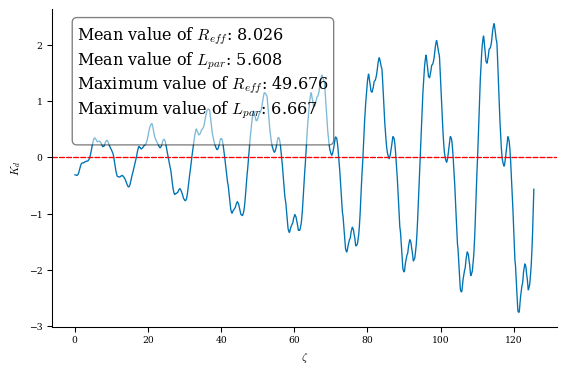

In [12]:
plot_Kd(eq2)

In [ ]:
eq2 = run_step(1,eq,grid,target_type="mean")

In [ ]:
plot_Kd(eq2)